In [8]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Masking, Dropout
from keras.models import Model, Sequential
import numpy as np
import pandas as pd

In [2]:
base_dir = '/home/vaibhavpawar/codes/online/'

In [3]:
#load data
mid = np.loadtxt(base_dir + 'mid.csv', dtype='int32', delimiter=',')
tid = np.loadtxt(base_dir + 'tid.csv', dtype='int32', delimiter=',')
ton = np.loadtxt(base_dir + 'ton.csv', dtype='int32', delimiter=',')
fecom = np.loadtxt(base_dir + 'fecom.csv', dtype='int32', delimiter=',')

In [5]:
mid.shape

(3508563, 19)

In [6]:
# split the data into a training, validation and test set
indices = np.arange(mid.shape[0])
np.random.shuffle(indices)

mid = mid[indices]
tid = tid[indices]
ton = ton[indices]
fecom = fecom[indices]

tr_pct = 0.7
vl_pct = 0.2

tr_nrec = int(tr_pct*mid.shape[0])
vl_nrec = int(vl_pct*mid.shape[0])
ts_nrec = mid.shape[0] - (tr_nrec + vl_nrec)

tr_indices = indices[0:tr_nrec]
vl_indices = indices[tr_nrec:tr_nrec+vl_nrec]
ts_indices = indices[-ts_nrec:]

x1_tr = mid[0:tr_nrec, :]
x2_tr = tid[0:tr_nrec, :]
x3_tr = ton[0:tr_nrec, :]
y_tr = fecom[0:tr_nrec]

x1_vl = mid[tr_nrec:tr_nrec+vl_nrec, :]
x2_vl = tid[tr_nrec:tr_nrec+vl_nrec, :]
x3_vl = ton[tr_nrec:tr_nrec+vl_nrec, :]
y_vl = fecom[tr_nrec:tr_nrec+vl_nrec]

x1_ts = mid[-ts_nrec:, :]
x2_ts = tid[-ts_nrec:, :]
x3_ts = ton[-ts_nrec:, :]
y_ts = fecom[-ts_nrec:]

In [9]:
time_steps1 = 19
onehot_vec_size1 = 42
time_steps2 = 16
onehot_vec_size2 = 37
time_steps3 = 22
onehot_vec_size3 = 50

lstm_size1 = 64
lstm_size2 = 64
lstm_size3 = 64

input1 = Input(shape=(time_steps1,), dtype='int32', name = 'input1')
input2 = Input(shape=(time_steps2,), dtype='int32', name = 'input2')
input3 = Input(shape=(time_steps3,), dtype='int32', name = 'input3')

# embedding layer to convert into one-hot encoded vector
# 0 is mapped to all zeros - this will be ignored when masked
# hence, 1st row of embedding matrix is all zero
# rest of the matrix is just an identity matrix
# this matrix is marked as non-trainable 

embedding_matrix1 = np.zeros((onehot_vec_size1 + 1, onehot_vec_size1))
embedding_matrix1[1:,:] = np.identity(onehot_vec_size1)

embedding_matrix2 = np.zeros((onehot_vec_size2 + 1, onehot_vec_size2))
embedding_matrix2[1:,:] = np.identity(onehot_vec_size2)

embedding_matrix3 = np.zeros((onehot_vec_size3 + 1, onehot_vec_size3))
embedding_matrix3[1:,:] = np.identity(onehot_vec_size3)

embedding_layer1 = Embedding(onehot_vec_size1 + 1,
                            onehot_vec_size1,
                            weights=[embedding_matrix1],
                            input_length=time_steps1,
                            trainable=False)

embedding_layer2 = Embedding(onehot_vec_size2 + 1,
                            onehot_vec_size2,
                            weights=[embedding_matrix2],
                            input_length=time_steps2,
                            trainable=False)

embedding_layer3 = Embedding(onehot_vec_size3 + 1,
                            onehot_vec_size3,
                            weights=[embedding_matrix3],
                            input_length=time_steps3,
                            trainable=False)

embedded_sequences1 = embedding_layer1(input1)
embedded_sequences2 = embedding_layer2(input2)
embedded_sequences3 = embedding_layer3(input3)

lstm1 = LSTM(lstm_size1, dropout=0.2, recurrent_dropout=0.2)
lstm2 = LSTM(lstm_size2, dropout=0.2, recurrent_dropout=0.2)
lstm3 = LSTM(lstm_size3, dropout=0.2, recurrent_dropout=0.2)

y1 = Masking(mask_value=0.0)(embedded_sequences1)
y2 = Masking(mask_value=0.0)(embedded_sequences2)
y3 = Masking(mask_value=0.0)(embedded_sequences3)

#sequence_out, y1h, state_c = lstm1(y1)
y1 = lstm1(y1)
y2 = lstm2(y2)
y3 = lstm3(y3)

y = concatenate([y1, y2, y3], axis=-1)
y = Dropout(0.3)(y)
y = Dense(1, activation='sigmoid')(y)

model = Model(inputs = [input1, input2, input3], outputs = y)

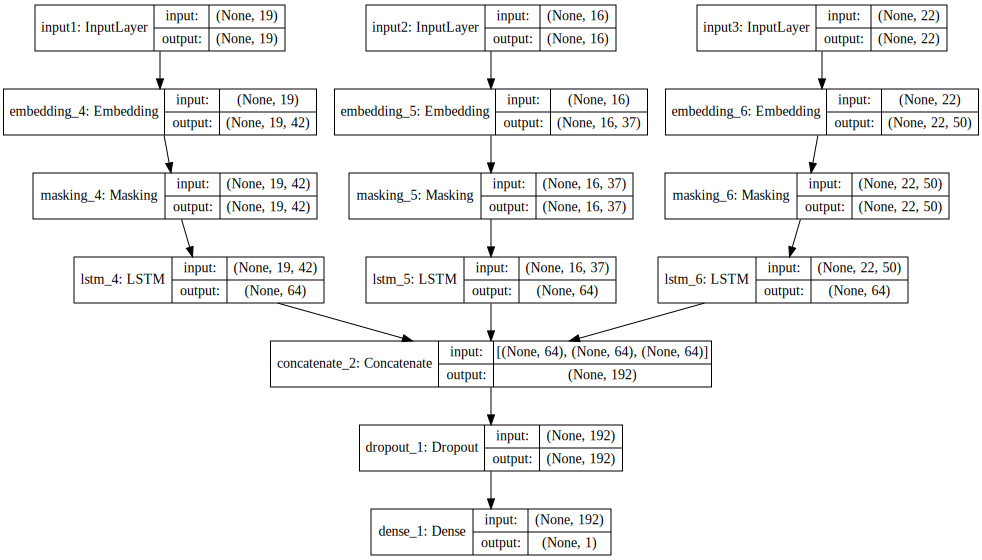

In [10]:
from keras.utils import plot_model
import pydot
pydot.find_graphviz = lambda: True

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [12]:
model.fit([x1_tr, x2_tr, x3_tr], y_tr,
          batch_size=64,
          epochs=5,
          validation_data=([x1_vl, x2_vl, x3_vl], y_vl))

Train on 2455994 samples, validate on 701712 samples
Epoch 1/5
2455994/2455994 [==============================] - 7013s - loss: 0.0163 - acc: 0.9955 - val_loss: 0.0072 - val_acc: 0.9980
Epoch 2/5
2455994/2455994 [==============================] - 6724s - loss: 0.0090 - acc: 0.9974 - val_loss: 0.0060 - val_acc: 0.9984
Epoch 3/5
2455994/2455994 [==============================] - 6078s - loss: 0.0073 - acc: 0.9980 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 4/5
2455994/2455994 [==============================] - 6322s - loss: 0.0064 - acc: 0.9982 - val_loss: 0.0046 - val_acc: 0.9988
Epoch 5/5
2455994/2455994 [==============================] - 5781s - loss: 0.0059 - acc: 0.9983 - val_loss: 0.0043 - val_acc: 0.9989


In [13]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [14]:
model.save(base_dir + 'lstm_epoch5.h5')

In [15]:
model.save_weights(base_dir + 'lstm_epoch5_weights.h5')

In [16]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = base_dir + 'model_weights_best.hdf5'
callbacks = get_callbacks(filepath=file_path, patience=2)

In [17]:
model.fit([x1_tr, x2_tr, x3_tr], y_tr,
          batch_size=64,
          epochs=10,
          validation_data=([x1_vl, x2_vl, x3_vl], y_vl),
          callbacks=callbacks)

Train on 2455994 samples, validate on 701712 samples
Epoch 1/10
2455994/2455994 [==============================] - 6325s - loss: 0.0055 - acc: 0.9984 - val_loss: 0.0043 - val_acc: 0.9989
Epoch 2/10
2455994/2455994 [==============================] - 6244s - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0040 - val_acc: 0.9989
Epoch 3/10
2455994/2455994 [==============================] - 5892s - loss: 0.0049 - acc: 0.9986 - val_loss: 0.0036 - val_acc: 0.9990
Epoch 4/10
2455994/2455994 [==============================] - 5890s - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0038 - val_acc: 0.9990
Epoch 5/10
2455994/2455994 [==============================] - 5612s - loss: 0.0047 - acc: 0.9986 - val_loss: 0.0037 - val_acc: 0.9990
Epoch 6/10
2455994/2455994 [==============================] - 5661s - loss: 0.0045 - acc: 0.9987 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 7/10
2455994/2455994 [==============================] - 5484s - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0035 - val_acc: 0.9990
Epoch 8/1

In [18]:
model.fit([x1_tr, x2_tr, x3_tr], y_tr,
          batch_size=64,
          epochs=10,
          validation_data=([x1_vl, x2_vl, x3_vl], y_vl),
          callbacks=callbacks)

Train on 2455994 samples, validate on 701712 samples
Epoch 1/10
2455994/2455994 [==============================] - 5584s - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0034 - val_acc: 0.9991
Epoch 2/10
2455994/2455994 [==============================] - 5612s - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0035 - val_acc: 0.9991
Epoch 3/10
2455994/2455994 [==============================] - 5596s - loss: 0.0042 - acc: 0.9988 - val_loss: 0.0034 - val_acc: 0.9991
Epoch 4/10
2455994/2455994 [==============================] - 5585s - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0034 - val_acc: 0.9991


In [112]:
model.save(base_dir + 'lstm_epoch19.h5')
model.save_weights(base_dir + 'lstm_epoch19_weights.h5')

In [20]:
# check test performance
y_ts_pred = model.predict([x1_ts, x2_ts, x3_ts])

In [24]:
from sklearn.metrics import log_loss

In [32]:
log_loss(y_ts, y_ts_pred, eps = 1e-5)

0.0034534780620771527

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
accuracy_score(y_ts, y_ts_pred>0.5)

0.9990366445588944

In [40]:
# get some samples to check outputs
from itertools import izip

base_dir = '/home/vaibhavpawar/codes/online/'
infile = base_dir + 'pnb_mtts.csv'
midfile = base_dir + 'mid.csv'
tidfile = base_dir + 'tid.csv'
tonfile = base_dir + 'ton.csv'
fecomfile = base_dir + 'fecom.csv'
infile1 = base_dir + 'mtts_test.csv'
midfile1 = base_dir + 'mid1.csv'
tidfile1 = base_dir + 'tid1.csv'
tonfile1 = base_dir + 'ton1.csv'
fecomfile1 = base_dir + 'fecom1.csv'

n = 0
with open(infile, 'rb') as file_buff,\
    open(midfile, 'rb') as midfile_buff,\
    open(tidfile, 'rb') as tidfile_buff,\
    open(tonfile, 'rb') as tonfile_buff,\
    open(fecomfile, 'rb') as fecomfile_buff,\
    open(infile1, 'ab') as file1_buff,\
    open(midfile1, 'ab') as midfile1_buff,\
    open(tidfile1, 'ab') as tidfile1_buff,\
    open(tonfile1, 'ab') as tonfile1_buff,\
    open(fecomfile1, 'ab') as fecomfile1_buff:
    for mtt, midx, tidx, tonx, fecom in izip(file_buff, midfile_buff, tidfile_buff, tonfile_buff, fecomfile_buff):
        if fecom[0] == '1':
            n += 1
            file1_buff.write(mtt)
            midfile1_buff.write(midx)
            tidfile1_buff.write(tidx)
            tonfile1_buff.write(tonx)
            fecomfile1_buff.write(fecom)
        if n > 100:
            break

In [41]:
#load data
mid1 = np.loadtxt(base_dir + 'mid1.csv', dtype='int32', delimiter=',')
tid1 = np.loadtxt(base_dir + 'tid1.csv', dtype='int32', delimiter=',')
ton1 = np.loadtxt(base_dir + 'ton1.csv', dtype='int32', delimiter=',')
fecom1 = np.loadtxt(base_dir + 'fecom1.csv', dtype='int32', delimiter=',')

In [42]:
y_check = model.predict([mid1, tid1, ton1])

In [111]:
#np.set_printoptions(suppress=True)
#print y_check

In [61]:
# play with random combinations

mid_chars = {'!': 481, ' ': 471156, '"': 9, "'": 433, '&': 430, ')': 11, '(': 37, '+': 1, '*': 100, '-': 182, ',': 53352, '/': 11, '.': 77229, '1': 3516238, '0': 28041669, '3': 2509638, '2': 2964261, '5': 2324381, '4': 3212275, '7': 2501380, '6': 1945264, '9': 1916284, '8': 1825414, ';': 6, '?': 1, '@': 9, ']': 1, '_': 887, 'a': 718274, 'c': 144121, 'b': 102896, 'e': 503500, 'd': 149804, 'g': 81468, 'f': 65763, 'i': 352320, 'h': 194741, 'k': 102466, 'j': 52597, 'm': 644220, 'l': 473611, 'o': 291086, 'n': 335197, 'q': 3729, 'p': 364200, 's': 566473, 'r': 408651, 'u': 139320, 't': 286142, 'w': 45704, 'v': 59682, 'y': 73774, 'x': 18222, 'z': 72910}
tid_chars = {'$': 23, '-': 22, ',': 19, '.': 28, '1': 3359486, '0': 4152293, '3': 2530035, '2': 2728388, '5': 2094379, '4': 3115013, '7': 2018844, '6': 1977548, '9': 2091190, '8': 2156015, '@': 64, '_': 2, 'a': 64839, 'c': 5326, 'b': 121011, 'e': 4416, 'd': 115988, 'g': 3195, 'f': 18839, 'i': 21859, 'h': 24897, 'k': 130680, 'j': 31559, 'm': 329392, 'l': 35521, 'o': 14227, 'n': 22144, 'q': 369, 'p': 89341, 's': 250389, 'r': 63081, 'u': 61879, 't': 48887, 'w': 4983, 'v': 648, 'y': 7285, 'x': 5354, 'z': 707}
ton_chars = {'!': 1617, ' ': 5616268, '#': 2699, '"': 521, '%': 16, '$': 8, "'": 3337, '&': 36125, ')': 3587, '(': 7754, '+': 138, '*': 87164, '-': 51463, ',': 148092, '/': 42524, '.': 272949, '1': 40667, '0': 24394, '3': 17442, '2': 28326, '5': 14422, '4': 16292, '7': 12486, '6': 11691, '9': 12970, '8': 11066, ';': 307, ':': 296, '=': 6, '?': 55, '>': 1, '@': 627, '[': 23, ']': 18, '\\': 7, '_': 17552, 'a': 6553741, '`': 533, 'c': 1607470, 'b': 842979, 'e': 4815680, 'd': 1571026, 'g': 882999, 'f': 596855, 'i': 3633032, 'h': 1973035, 'k': 844990, 'j': 440792, 'm': 1887134, 'l': 2774793, 'o': 2645765, 'n': 3120072, 'q': 34222, 'p': 1344131, 's': 3877147, 'r': 3919487, 'u': 1242518, 't': 3148072, 'w': 557788, 'v': 736777, 'y': 733954, 'x': 121981, '{': 2, 'z': 268576, '}': 1}

mid_val_chars = "&' ,.0123456789abcdefghijklmnopqrstuvwxyz"
tid_val_chars = "0123456789abcdefghijklmnopqrstuvwxyz"
ton_val_chars = "#')(@ &*-,/._0123456789abcdefghijklmnopqrstuvwxyz"

def get_char_mapping(inp, val_chars):
    op = inp.copy()
    n2 = 1 
    for key in op:
        if key in val_chars:
            n2 += 1
            op[key] = str(n2)
        else:
            op[key] = '1'
        
    op['^'] = '0'
    return op

mid_chars1 = get_char_mapping(mid_chars, mid_val_chars)
tid_chars1 = get_char_mapping(tid_chars, tid_val_chars)
ton_chars1 = get_char_mapping(ton_chars, ton_val_chars)

def prepend_unk(instr, maxlen):
    instr = instr.strip()
    unk_str = ''.join(['^' for i in range(0, maxlen-len(instr))])
    return unk_str + instr

In [115]:
#KAIR62924008692_VISA_VISA
mid2s = 'KAIR62924008692'
tid2s = 'VISA'
ton2s = 'VISA'
mid2 = np.fromstring(','.join(mid_chars1[midc] for midc in prepend_unk(mid2s.lower(), 19)), 
                     dtype='int32', sep=',').reshape((1,19))
tid2 = np.fromstring(','.join(tid_chars1[tidc] for tidc in prepend_unk(tid2s.lower(), 16)),
                     dtype='int32', sep=',').reshape((1,16))
ton2 = np.fromstring(','.join(ton_chars1[tonc] for tonc in prepend_unk(ton2s.lower(), 22)),
                     dtype='int32', sep=',').reshape((1,22))
# print prob of online
model.predict([mid2, tid2, ton2])

array([[ 0.994]], dtype=float32)

array([[ 0.082]], dtype=float32)

In [58]:
mid2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape((1,19))
#mid2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,14,11,7,8,10,14,13]).reshape((1,19))
tid2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape((1,16))
#ton2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,17,47,17,16,19,38,22,37,24,38]).reshape((1,22))
#ton2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape((1,22))
ton2 = np.array([0,0,0,0,0,0,44,38,17,40,47,17,2,19,48,20,39,17,2,17,45,44]).reshape((1,22))

In [59]:
model.predict([mid2, tid2, ton2])

array([[ 0.105]], dtype=float32)

In [116]:
from keras.models import load_model

model1 = load_model(base_dir + 'lstm_epoch19.h5')

In [117]:
model1.predict([mid2, tid2, ton2])

array([[ 0.994]], dtype=float32)